# **House Price Prediction**

# 1 - Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from scipy import stats
from scipy.stats import boxcox
import xgboost as xgb

In [3]:
# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

# 2 - Load and examine data quality

In [4]:
# Load the dataset
df = pd.read_csv('data.csv')

In [5]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [6]:
print(f"Dataset shape: {df.shape}")

Dataset shape: (4600, 18)


In [7]:
print("\nData types:")
print(df.dtypes)


Data types:
date              object
price            float64
bedrooms         float64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
street            object
city              object
statezip          object
country           object
dtype: object


In [10]:
print("\nBasic statistics:")
df.describe().T


Basic statistics:


,count,mean,std,min,25%,50%,75%,max
price,4600.0,551962.988473,563834.702547,0.0,322875.00,460943.461539,654962.50,26590000.0
bedrooms,4600.0,3.400870,0.908848,0.0,3.00,3.000000,4.00,9.0
bathrooms,4600.0,2.160815,0.783781,0.0,1.75,2.250000,2.50,8.0
sqft_living,4600.0,2139.346957,963.206916,370.0,1460.00,1980.000000,2620.00,13540.0
sqft_lot,4600.0,14852.516087,35884.436145,638.0,5000.75,7683.000000,11001.25,1074218.0
floors,4600.0,1.512065,0.538288,1.0,1.00,1.500000,2.00,3.5
waterfront,4600.0,0.007174,0.084404,0.0,0.00,0.000000,0.00,1.0
view,4600.0,0.240652,0.778405,0.0,0.00,0.000000,0.00,4.0
condition,4600.0,3.451739,0.677230,1.0,3.00,3.000000,4.00,5.0
sqft_above,4600.0,1827.265435,862.168977,370.0,1190.00,1590.000000,2300.00,9410.0


In [11]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

Duplicate rows: 0


In [12]:
# Check for zero/negative prices
if 'price' in df.columns:
    invalid_prices = df[df['price'] <= 0].shape[0]
    print(f"Invalid prices (≤0): {invalid_prices}")

Invalid prices (≤0): 49


In [13]:
# Check for unrealistic values
if 'bedrooms' in df.columns:
    high_bedrooms = df[df['bedrooms'] > 10].shape[0]
    print(f"Properties with >10 bedrooms: {high_bedrooms}")

Properties with >10 bedrooms: 0


In [14]:
if 'bathrooms' in df.columns:
    high_bathrooms = df[df['bathrooms'] > 8].shape[0]
    print(f"Properties with >8 bathrooms: {high_bathrooms}")

Properties with >8 bathrooms: 0


# 3 - Data Cleaning

In [15]:
# Create a copy for cleaning
df_clean = df.copy()

In [16]:
# Remove invalid prices
if 'price' in df_clean.columns:
    initial_count = len(df_clean)
    df_clean = df_clean[df_clean['price'] > 0]
    removed = initial_count - len(df_clean)
    if removed > 0:
        print(f"✓ Removed {removed} rows with invalid prices")

✓ Removed 49 rows with invalid prices


In [17]:
# Handle extreme outliers
# Remove only the most extreme outliers (beyond 3 standard deviations)
for col in ['price', 'sqft_living', 'sqft_lot']:
    if col in df_clean.columns:
        z_scores = np.abs(stats.zscore(df_clean[col]))
        initial_count = len(df_clean)
        df_clean = df_clean[z_scores < 3]
        removed = initial_count - len(df_clean)
        if removed > 0:
            print(f"✓ Removed {removed} extreme outliers from {col}")

✓ Removed 34 extreme outliers from price
✓ Removed 44 extreme outliers from sqft_living
✓ Removed 70 extreme outliers from sqft_lot


In [18]:
# Convert data types
if 'date' in df_clean.columns:
    df_clean['date'] = pd.to_datetime(df_clean['date'])

In [19]:
# Fill missing values intelligently
for col in ['yr_renovated']:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].fillna(0)

In [20]:
print(f"Final dataset shape after cleaning: {df_clean.shape}")

Final dataset shape after cleaning: (4403, 18)


# 4 - Feature Engineering

In [21]:
current_year = datetime.now().year

In [22]:
# Basic engineered features
if 'yr_built' in df_clean.columns:
    df_clean['house_age'] = current_year - df_clean['yr_built']
    df_clean['age_squared'] = df_clean['house_age'] ** 2  # Non-linear age effect

In [23]:
if 'yr_renovated' in df_clean.columns:
    df_clean['is_renovated'] = (df_clean['yr_renovated'] > 0).astype(int)
    df_clean['years_since_renovation'] = np.where(
        df_clean['yr_renovated'] == 0,
        df_clean['house_age'],
        current_year - df_clean['yr_renovated']
    )

In [24]:
# Size and ratio features
if all(col in df_clean.columns for col in ['price', 'sqft_living']):
    df_clean['price_per_sqft'] = df_clean['price'] / df_clean['sqft_living']

if all(col in df_clean.columns for col in ['sqft_living', 'sqft_lot']):
    df_clean['living_to_lot_ratio'] = df_clean['sqft_living'] / df_clean['sqft_lot']
    df_clean['total_sqft'] = df_clean['sqft_living'] + df_clean.get('sqft_basement', 0)

In [25]:
# Interaction features (important for capturing complex relationships)
if all(col in df_clean.columns for col in ['bedrooms', 'bathrooms']):
    df_clean['bed_bath_ratio'] = df_clean['bedrooms'] / (df_clean['bathrooms'] + 0.1)  # Avoid division by zero
    df_clean['total_rooms'] = df_clean['bedrooms'] + df_clean['bathrooms']

if all(col in df_clean.columns for col in ['sqft_living', 'bedrooms']):
    df_clean['sqft_per_bedroom'] = df_clean['sqft_living'] / (df_clean['bedrooms'] + 0.1)

In [26]:
# Quality score combination
quality_features = ['view', 'condition']
available_quality = [col for col in quality_features if col in df_clean.columns]
if len(available_quality) >= 2:
    df_clean['quality_score'] = df_clean[available_quality].sum(axis=1)

In [27]:
# Location-based features
if 'city' in df_clean.columns:
    # Create city dummy variables (one-hot encoding)
    city_dummies = pd.get_dummies(df_clean['city'], prefix='city')
    df_clean = pd.concat([df_clean, city_dummies], axis=1)

    # City-based statistics
    city_stats = df_clean.groupby('city')['price'].agg(['mean', 'std', 'count']).reset_index()
    city_stats.columns = ['city', 'city_avg_price', 'city_price_std', 'city_count']
    df_clean = df_clean.merge(city_stats, on='city', how='left')

In [28]:
# Time-based features
if 'date' in df_clean.columns:
    df_clean['sale_month'] = df_clean['date'].dt.month
    df_clean['sale_year'] = df_clean['date'].dt.year
    df_clean['sale_quarter'] = df_clean['date'].dt.quarter
    df_clean['is_summer'] = df_clean['sale_month'].isin([6, 7, 8]).astype(int)

In [29]:
# Log transformations for skewed features
skewed_features = ['sqft_living', 'sqft_lot', 'sqft_above']
for feature in skewed_features:
    if feature in df_clean.columns and df_clean[feature].min() > 0:
        df_clean[f'log_{feature}'] = np.log1p(df_clean[feature])

In [30]:
print(f"Dataset shape after feature engineering: {df_clean.shape}")

Dataset shape after feature engineering: (4403, 83)


# 5 - Target Variable Analysis and Transformation

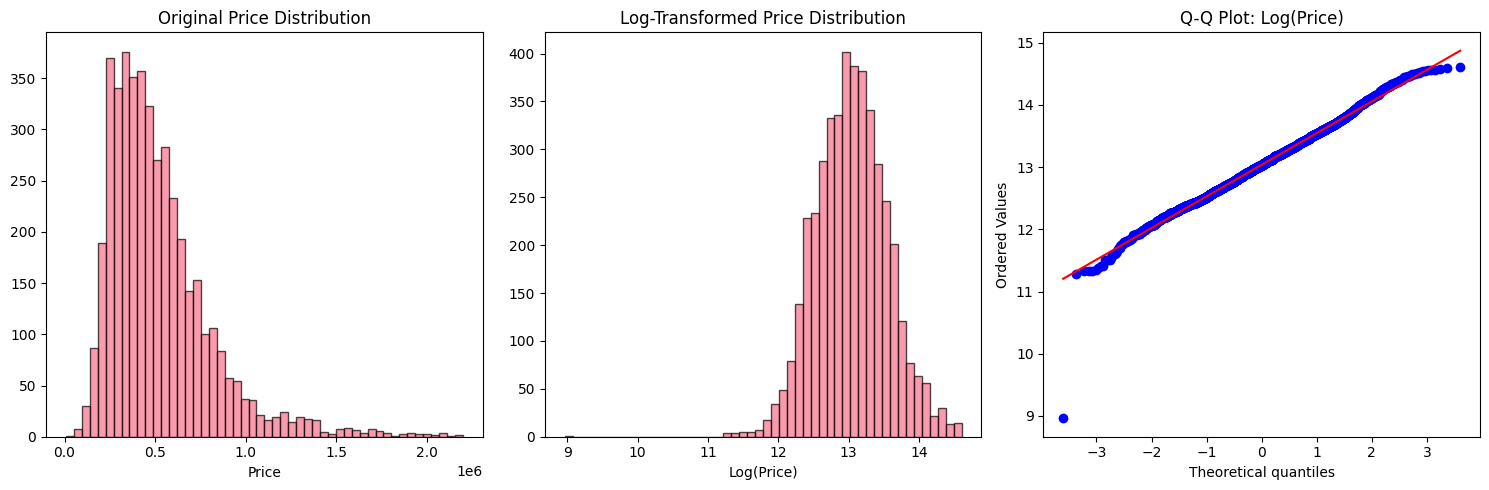

Original price skewness: 1.8240
Log price skewness: -0.0246


In [31]:
# Analyze price distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(df_clean['price'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Original Price Distribution')
plt.xlabel('Price')

# Apply log transformation to price
df_clean['log_price'] = np.log(df_clean['price'])

plt.subplot(1, 3, 2)
plt.hist(df_clean['log_price'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Log-Transformed Price Distribution')
plt.xlabel('Log(Price)')

# Check normality
plt.subplot(1, 3, 3)
stats.probplot(df_clean['log_price'], dist="norm", plot=plt)
plt.title('Q-Q Plot: Log(Price)')

plt.tight_layout()
plt.show()

# Print transformation results
print(f"Original price skewness: {df_clean['price'].skew():.4f}")
print(f"Log price skewness: {df_clean['log_price'].skew():.4f}")

# 6 - Feature Selection

In [32]:
# Prepare features for modeling
exclude_columns = ['price', 'log_price', 'date', 'street', 'city', 'statezip', 'country']
potential_features = [col for col in df_clean.columns if col not in exclude_columns]

In [34]:
# Remove features with too many missing values or low variance
final_features = []
for col in potential_features:
    if df_clean[col].dtype in ['int64', 'float64', 'int8', 'int16', 'float32']:
        # Check for sufficient variance
        if df_clean[col].var() > 1e-6:
            final_features.append(col)

In [35]:
print(f"Selected {len(final_features)} features for modeling")

Selected 30 features for modeling


In [36]:
# Handle any remaining missing values
X = df_clean[final_features].fillna(df_clean[final_features].median())
y = df_clean['log_price']  # Use log-transformed target

In [39]:
# Use SelectKBest to find most relevant features
selector = SelectKBest(score_func=f_regression, k=min(50, len(final_features)))
X_selected = selector.fit_transform(X, y)
selected_features = [final_features[i] for i in selector.get_support(indices=True)]

print(f"Top {len(selected_features)} most relevant features selected")
print("Selected features:", selected_features)

Top 30 most relevant features selected
Selected features: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'house_age', 'age_squared', 'is_renovated', 'years_since_renovation', 'price_per_sqft', 'living_to_lot_ratio', 'total_sqft', 'bed_bath_ratio', 'total_rooms', 'sqft_per_bedroom', 'quality_score', 'city_avg_price', 'city_price_std', 'city_count', 'is_summer', 'log_sqft_living', 'log_sqft_lot', 'log_sqft_above']


# 7 - Models Training and Evaluation

In [40]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (3522, 30)
Test set size: (881, 30)


In [41]:
# Use RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [42]:
# Models dictionary with parameters
models = {
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ),
    'Extra Trees': ExtraTreesRegressor(
        n_estimators=200,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
}

In [43]:
# Store results
model_results = {}

In [44]:
# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Use scaled data for linear models, original data for tree-based models
    if 'Regression' in name and 'Forest' not in name and 'Trees' not in name:
        # Cross-validation
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # Transform predictions back to original price scale
    y_pred_original = np.exp(y_pred)
    y_test_original = np.exp(y_test)

    # Calculate metrics on original scale
    mse = mean_squared_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_original, y_pred_original)
    r2 = r2_score(y_test_original, y_pred_original)

    # Calculate metrics on log scale too
    r2_log = r2_score(y_test, y_pred)

    # Store results
    model_results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R²_original': r2,
        'R²_log': r2_log,
        'CV_mean': cv_scores.mean(),
        'CV_std': cv_scores.std(),
        'model': model
    }

    print(f"Results for {name}:")
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  MAE: ${mae:,.2f}")
    print(f"  R² (original scale): {r2:.4f}")
    print(f"  R² (log scale): {r2_log:.4f}")
    print(f"  CV R² (mean ± std): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Training Ridge Regression...
Results for Ridge Regression:
  RMSE: $82,080.51
  MAE: $36,868.45
  R² (original scale): 0.9180
  R² (log scale): 0.9650
  CV R² (mean ± std): 0.9367 ± 0.0279

Training Lasso Regression...
Results for Lasso Regression:
  RMSE: $146,114.41
  MAE: $99,428.72
  R² (original scale): 0.7400
  R² (log scale): 0.7827
  CV R² (mean ± std): 0.7683 ± 0.0170

Training Random Forest...
Results for Random Forest:
  RMSE: $21,274.15
  MAE: $8,029.74
  R² (original scale): 0.9945
  R² (log scale): 0.9970
  CV R² (mean ± std): 0.9866 ± 0.0124

Training Extra Trees...
Results for Extra Trees:
  RMSE: $24,744.05
  MAE: $8,240.63
  R² (original scale): 0.9925
  R² (log scale): 0.9959
  CV R² (mean ± std): 0.9813 ± 0.0137

Training Gradient Boosting...
Results for Gradient Boosting:
  RMSE: $17,665.29
  MAE: $8,549.89
  R² (original scale): 0.9962
  R² (log scale): 0.9978
  CV R² (mean ± std): 0.9879 ± 0.0105


# 8 - Models Comparison and Results

In [45]:
# Create detailed results DataFrame
results_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'RMSE': [results['RMSE'] for results in model_results.values()],
    'MAE': [results['MAE'] for results in model_results.values()],
    'R²_Original': [results['R²_original'] for results in model_results.values()],
    'R²_Log': [results['R²_log'] for results in model_results.values()],
    'CV_R²_Mean': [results['CV_mean'] for results in model_results.values()],
    'CV_R²_Std': [results['CV_std'] for results in model_results.values()]
})

results_df.round(4)

,Model,RMSE,MAE,R²_Original,R²_Log,CV_R²_Mean,CV_R²_Std
0,Ridge Regression,82080.5061,36868.4488,0.9180,0.9650,0.9367,0.0279
1,Lasso Regression,146114.4143,99428.7158,0.7400,0.7827,0.7683,0.0170
2,Random Forest,21274.1504,8029.7434,0.9945,0.9970,0.9866,0.0124
3,Extra Trees,24744.0495,8240.6260,0.9925,0.9959,0.9813,0.0137
4,Gradient Boosting,17665.2862,8549.8917,0.9962,0.9978,0.9879,0.0105


In [46]:
# Identify best model
best_model_name = results_df.loc[results_df['R²_Original'].idxmax(), 'Model']
best_r2 = results_df['R²_Original'].max()

print(f"\nBest performing model: {best_model_name}")
print(f"Best R² score: {best_r2:.4f}")


Best performing model: Gradient Boosting
Best R² score: 0.9962


# 9 - Feature Importance Analysis

Top 15 Most Important Features (Gradient Boosting):
             feature  importance
16    price_per_sqft    0.518527
2        sqft_living    0.235836
27   log_sqft_living    0.231471
18        total_sqft    0.009292
24    city_price_std    0.001544
29    log_sqft_above    0.001111
8         sqft_above    0.000678
10          yr_built    0.000198
22     quality_score    0.000196
23    city_avg_price    0.000145
21  sqft_per_bedroom    0.000145
25        city_count    0.000131
1          bathrooms    0.000096
7          condition    0.000082
13       age_squared    0.000079


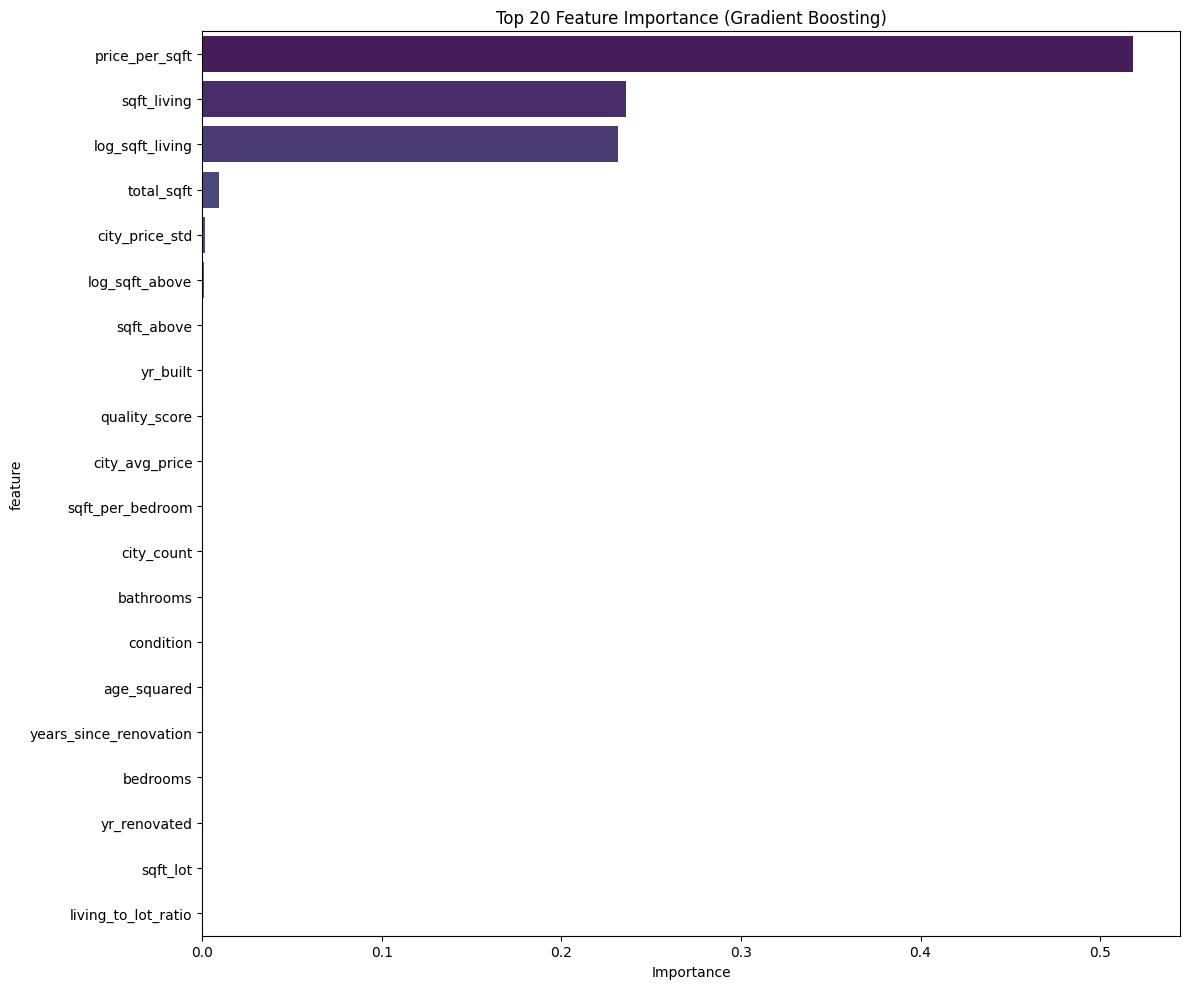

In [47]:
# Get feature importance from best tree-based model
tree_models = ['Random Forest', 'Extra Trees', 'Gradient Boosting']
best_tree_model = None
best_tree_r2 = -1

for model_name in tree_models:
    if model_name in model_results and model_results[model_name]['R²_original'] > best_tree_r2:
        best_tree_model = model_results[model_name]['model']
        best_tree_r2 = model_results[model_name]['R²_original']
        best_tree_name = model_name

if best_tree_model is not None:
    feature_importance = pd.DataFrame({
        'feature': selected_features,
        'importance': best_tree_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"Top 15 Most Important Features ({best_tree_name}):")
    print(feature_importance.head(15))

    # Visualize feature importance
    plt.figure(figsize=(12, 10))
    top_features = feature_importance.head(20)
    sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
    plt.title(f'Top 20 Feature Importance ({best_tree_name})')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()


=== RESIDUAL ANALYSIS ===


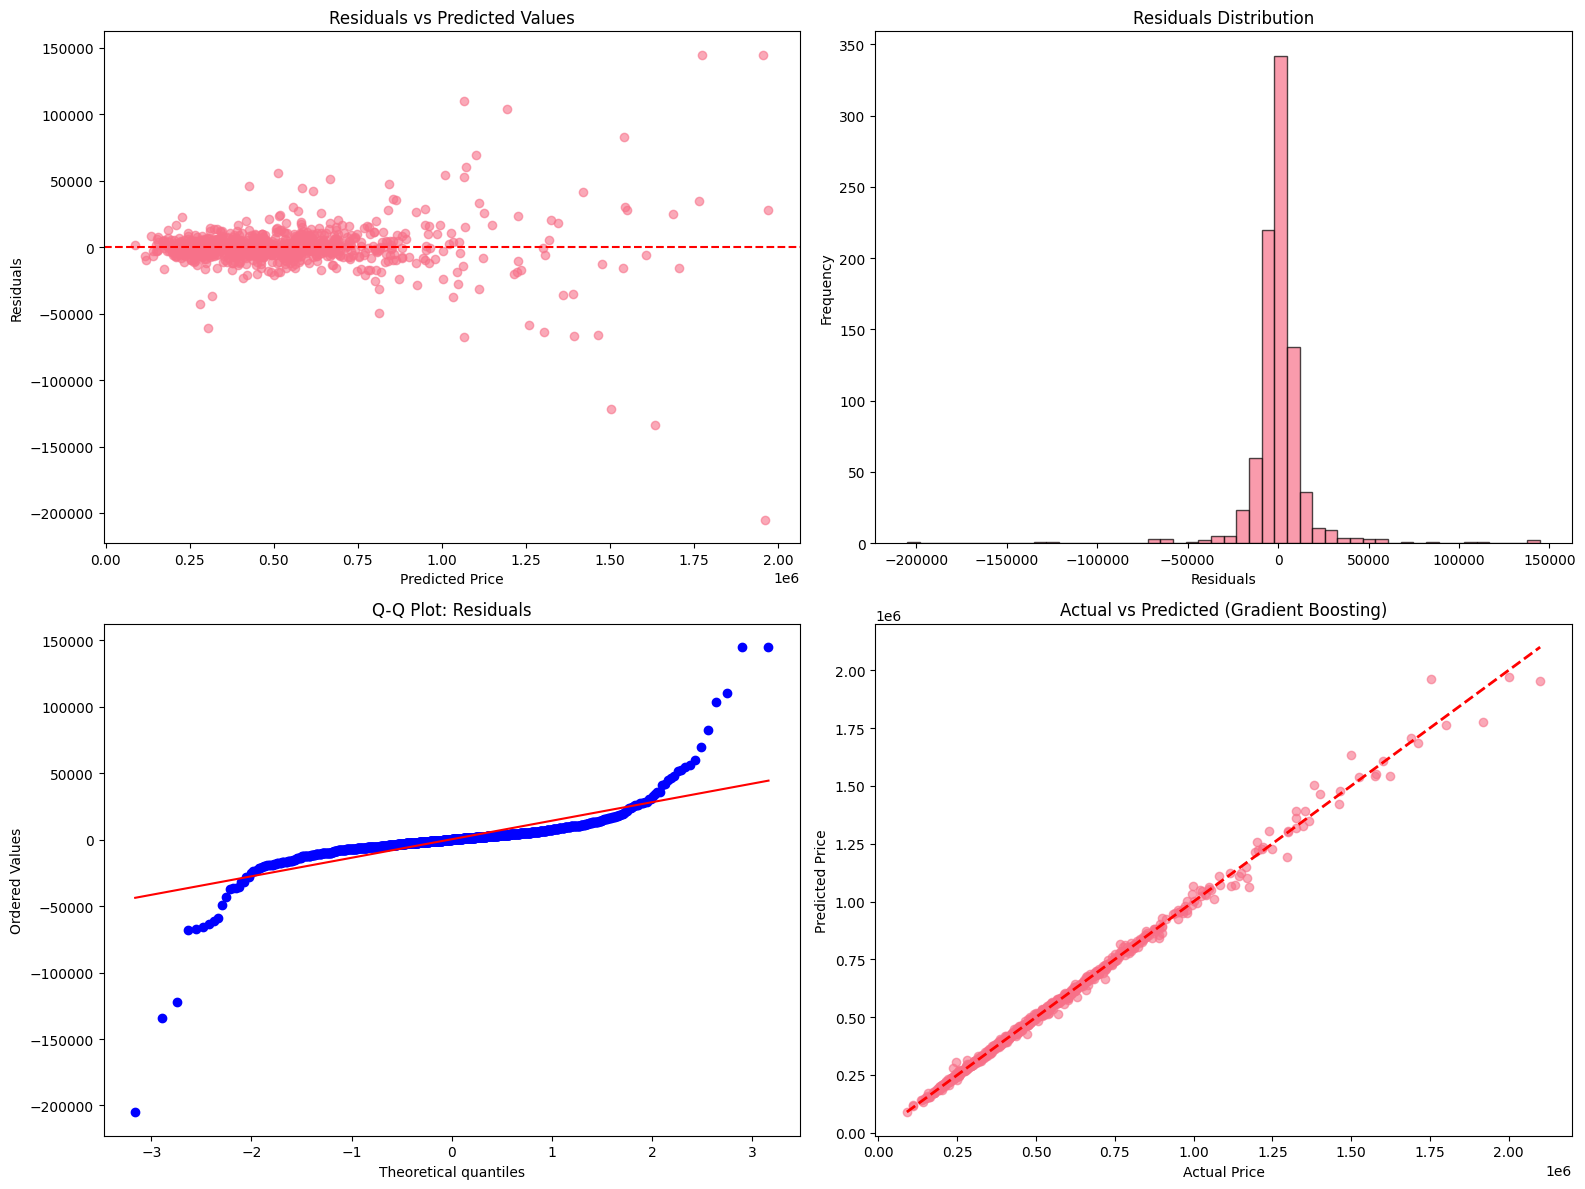

In [48]:
print("\n=== RESIDUAL ANALYSIS ===")

# Analyze residuals for the best model
best_model = model_results[best_model_name]['model']

if 'Regression' in best_model_name and 'Forest' not in best_model_name:
    y_pred_best = best_model.predict(X_test_scaled)
else:
    y_pred_best = best_model.predict(X_test)

# Convert to original scale
y_pred_best_original = np.exp(y_pred_best)
y_test_original = np.exp(y_test)

residuals = y_test_original - y_pred_best_original

# Plot residuals
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Residuals vs Predicted
axes[0, 0].scatter(y_pred_best_original, residuals, alpha=0.6)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Predicted Price')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Predicted Values')

# Residuals histogram
axes[0, 1].hist(residuals, bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Residuals Distribution')

# Q-Q plot of residuals
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot: Residuals')

# Actual vs Predicted
axes[1, 1].scatter(y_test_original, y_pred_best_original, alpha=0.6)
axes[1, 1].plot([y_test_original.min(), y_test_original.max()],
                [y_test_original.min(), y_test_original.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Actual Price')
axes[1, 1].set_ylabel('Predicted Price')
axes[1, 1].set_title(f'Actual vs Predicted ({best_model_name})')

plt.tight_layout()
plt.show()

In [49]:
print(f"\nFinal Results:")
print(f"• Best Model: {best_model_name}")
print(f"• R² Score: {best_r2:.4f}")
print(f"• RMSE: ${results_df.loc[results_df['R²_Original'].idxmax(), 'RMSE']:,.2f}")
print(f"• Cross-validation R²: {results_df.loc[results_df['R²_Original'].idxmax(), 'CV_R²_Mean']:.4f} ± {results_df.loc[results_df['R²_Original'].idxmax(), 'CV_R²_Std']:.4f}")



Final Results:
• Best Model: Gradient Boosting
• R² Score: 0.9962
• RMSE: $17,665.29
• Cross-validation R²: 0.9879 ± 0.0105
